In [1]:
import pandas as pd
import os
%pip install openpyxl
import openpyxl
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
%pip install ace_tools
%pip install pyspark
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Develop

Load Data Frame and append all sheets to one

In [2]:
# Reload the Excel file to ensure the most recent upload is used
file_path = 'Test.xlsx'
excel_data = pd.ExcelFile(file_path)

# Read all sheets into a dictionary of DataFrames
all_sheets = {sheet_name: excel_data.parse(sheet_name) for sheet_name in excel_data.sheet_names}

# Combine all sheets into one DataFrame
combined_data = pd.concat(all_sheets.values(), ignore_index=True)



# Data Preprocessing

Filter all data and remove any unecessary metrics

In [3]:
# Correct the filtering process to ensure all rows containing "(Raw score)" or "(raw score)" are removed.
filtered_data = combined_data[~combined_data['Participant #'].str.contains(r'\(Raw score\)|\(raw score\)', na=False)]

# List of metrics to remove
metrics_to_remove = [
    'PlayAttention Points', 'Subjective sleep quality', 'Sleep latency',
    'Sleep duration', 'Sleep efficiency', 'Sleep disturbance', 'Use of sleep medication',
    'Daytime disturbance', 'Agreeableness', 'Extraversion', 'Openness', '2 feet errors (eyes open)',
    'tandem errors', '1 foot errors', '2 feet Eyes closed errors', 'tandem Eyes closed errors',
    '1 foot Eyes closed errors'
]

# Remove rows where the "Participant #" column matches any of the metrics to remove
filtered_data = filtered_data[~filtered_data['Participant #'].isin(metrics_to_remove)]

filtered_data


,Participant #,100,101,102,103,104,105,106,Unnamed: 8,200,...,Unnamed: 70,Unnamed: 78,Unnamed: 86,Unnamed: 94,Unnamed: 95,Unnamed: 104,Unnamed: 111,Unnamed: 119,Unnamed: 127,Unnamed: 135
0,Metric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Creyos Cognitive score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Creyos monkey ladder (Age matched score),102.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Creyos monkey ladder (Percentile),55.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Creyos monkey ladder (Percentile),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Grip Strength (KG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,R hand average strength,12.3,25.3,NaN,NaN,NaN,NaN,NaN,NaN,21.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,Norms R-Hand,28.4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,28.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,L hand average strength,12,28,NaN,NaN,NaN,NaN,NaN,NaN,19.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Transposing Data

In [4]:

# Transpose the DataFrame
transposed_data = filtered_data.transpose()

# Add 'Participant #' as the first column name
transposed_data.columns = transposed_data.iloc[0]
transposed_data = transposed_data.drop(transposed_data.index[0])
transposed_data.reset_index(inplace=True)
transposed_data.rename(columns={'index': 'Participant #'}, inplace=True)

transposed_data = transposed_data.dropna(how='all', subset=transposed_data.columns[1:])

transposed_data = transposed_data.dropna(axis=1, how='all')

transposed_data = transposed_data.dropna(subset=['Creyos monkey ladder (Age matched score)'])


# Save the transposed data to a new CSV file
transposed_csv_path = 'data_transposed.csv'
transposed_data.to_csv(transposed_csv_path, index=False)


## Correlation Map

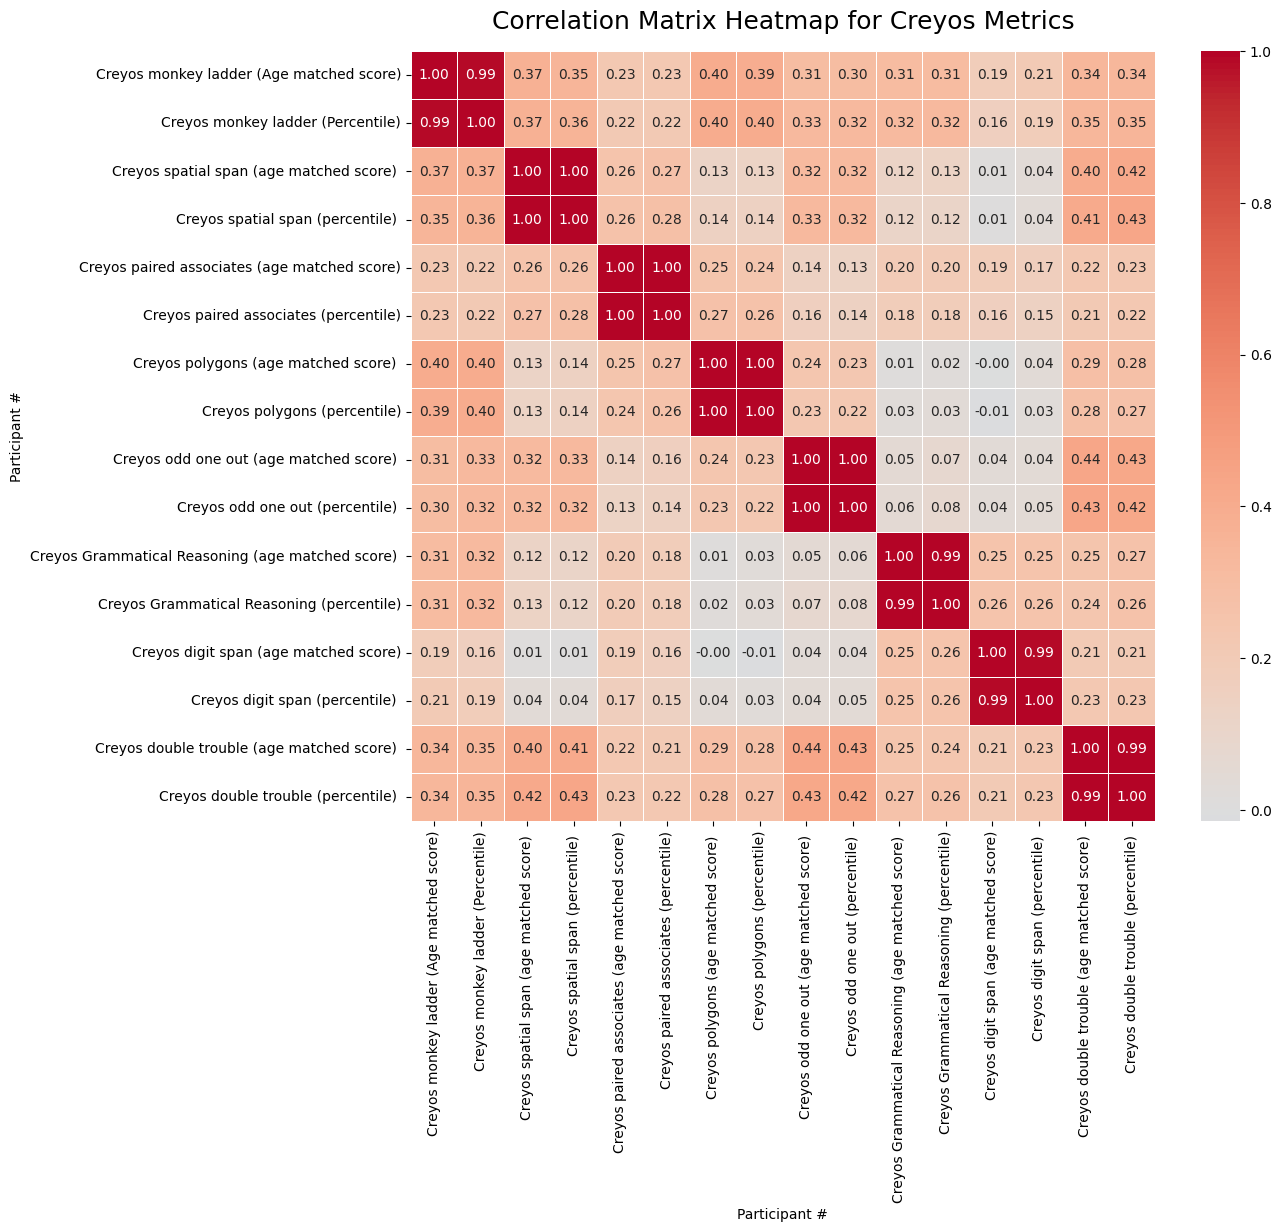

In [5]:
#take a snippet of the transposed data to see the creyos correlations

filtered_data= transposed_data
filtered_data.columns = filtered_data.columns.astype(str)

# Filter the DataFrame to include only columns with "Creyos" in the name
creyos_columns = [col for col in filtered_data.columns if "Creyos" in col]
filtered_creyos_data = filtered_data[creyos_columns]

# Convert columns to numeric
filtered_creyos_data = filtered_creyos_data.apply(pd.to_numeric, errors='coerce')

# Calculate the correlation matrix
correlation_matrix = filtered_creyos_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5, fmt='.2f')
heatmap.set_title('Correlation Matrix Heatmap for Creyos Metrics', fontdict={'fontsize': 18}, pad=16)

# Show the plot
plt.show()

In [6]:
#Remove any multicollinear variables

transposed_data.columns = transposed_data.columns.astype(str)

creyos_columns = [col for col in transposed_data.columns if "Creyos" in col]
filtered_creyos_data = transposed_data[creyos_columns].apply(pd.to_numeric, errors='coerce')
correlation_matrix = filtered_creyos_data.corr()

correlation_threshold = 0.75
columns_to_retain = set(correlation_matrix.columns)
columns_to_remove = set()

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.at[idx, col]) > correlation_threshold:
            if col in columns_to_retain and idx in columns_to_retain:
                # Keep only one column from the set
                columns_to_retain.discard(idx)
                columns_to_remove.add(idx)

transposed_data_cleaned = transposed_data.drop(columns=columns_to_remove, errors='ignore')

updated_transposed_csv_path = 'cleaned_data4.csv'
transposed_data_cleaned.to_csv(updated_transposed_csv_path, index=False)

print(f"Columns removed due to multicollinearity: {columns_to_remove}")
print(f"Columns retained: {columns_to_retain}")
print(f"Cleaned transposed data saved to {updated_transposed_csv_path}")

data=transposed_data_cleaned

Columns removed due to multicollinearity: {'Creyos Grammatical Reasoning (percentile)', 'Creyos polygons (percentile)', 'Creyos double trouble (percentile) ', 'Creyos digit span (percentile) ', 'Creyos paired associates (percentile)', 'Creyos odd one out (percentile) ', 'Creyos spatial span (percentile) ', 'Creyos monkey ladder (Percentile)'}
Columns retained: {'Creyos monkey ladder (Age matched score)', 'Creyos Grammatical Reasoning (age matched score) ', 'Creyos paired associates (age matched score)', 'Creyos digit span (age matched score)', 'Creyos spatial span (age matched score) ', 'Creyos double trouble (age matched score) ', 'Creyos polygons (age matched score) ', 'Creyos odd one out (age matched score) '}
Cleaned transposed data saved to cleaned_data4.csv


## Converting all Improper Data Columns

In [7]:

import re

def convert_height_to_cm(height):
    if isinstance(height, str):
        # Match feet and inches using regex (e.g., 5'3)
        match = re.match(r"(\d+)'(\d+)", height)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            return feet * 30.48 + inches * 2.54
    elif isinstance(height, (int, float)):
        return height  # Already in cm
    return None



def convert_weight_to_kg(weight):
    if isinstance(weight, (int, float)):
        if weight < 100:  # Assuming weights over 200 are already in kg, adjust this logic as needed
            return weight
        else:
            return weight * 0.453592  # Convert lbs to kg
    return None
data.head()


import pandas as pd
import numpy as np

# Define function to impute missing values based on the specified age bins
def impute_missing_values(data):
    # Define the age bins based on the 'participant #' column
    bins = [100, 400, 800, 1200, np.inf]
    labels = ['100-399', '400-799', '800-1199', '1200+']
    
    # Create a new column 'age_bin' that categorizes the participant numbers into age ranges
    data['age_bin'] = pd.cut(data['participant #'], bins=bins, labels=labels, right=False)

    # Calculate the mean for each bin, excluding the 'Concussion#' column
    means = data.groupby('age_bin').mean().drop(columns=['Concussion#'])

    # Impute missing values with the corresponding bin mean
    for label in labels:
        mean_values = means.loc[label]
        columns_to_fill = mean_values.index.tolist()  # Columns except 'Concussion#'
        data.loc[(data['age_bin'] == label) & (data[columns_to_fill].isnull().any(axis=1)), columns_to_fill] = data.loc[(data['age_bin'] == label) & (data[columns_to_fill].isnull().any(axis=1)), columns_to_fill].fillna(mean_values)
    
    # Drop the 'age_bin' column as it's no longer needed
    data.drop(columns=['age_bin'], inplace=True)

    return data



print(data.dtypes)
print(list(data.columns))


Participant #
Participant #                                   object
Creyos monkey ladder (Age matched score)        object
Creyos spatial span (age matched score)         object
Creyos paired associates (age matched score)    object
Creyos polygons (age matched score)             object
                                                 ...  
Changes after vagus basic exercise              object
R hand average  strength                        object
Norms R-Hand                                    object
L hand average  strength                        object
Norms L-Hand                                    object
Length: 132, dtype: object
['Participant #', 'Creyos monkey ladder (Age matched score)', 'Creyos spatial span (age matched score) ', 'Creyos paired associates (age matched score)', 'Creyos polygons (age matched score) ', 'Creyos odd one out (age matched score) ', 'Creyos Grammatical Reasoning (age matched score) ', 'Creyos digit span (age matched score)', 'Creyos double trouble 

In [8]:
data['height'] = data['height'].apply(convert_height_to_cm)
data['weight'] = data['weight'].apply(convert_weight_to_kg)
data['ADHD'] = data['ADHD'].apply(lambda x: 0 if x=='No' else 1)
data['Migraines']= data['Migraines'].apply(lambda x: 0 if x== 'No' else 1)

data['L hand average  strength'] = pd.to_numeric(data['L hand average  strength'], errors='coerce')
data['Norms L-Hand'] = pd.to_numeric(data['Norms L-Hand'], errors='coerce')

# Fill NaN values with 0 or another appropriate value before converting to int
data['L hand average  strength'] = data['L hand average  strength'].fillna(0).astype(int)
data['Norms L-Hand'] = data['Norms L-Hand'].fillna(0).astype(int)

# Perform the division to normalize the strength
data['L hand average  strength'] = data['L hand average  strength'] / data['Norms L-Hand']


data['R hand average  strength'] = pd.to_numeric(data['R hand average  strength'], errors='coerce')
data['Norms R-Hand'] = pd.to_numeric(data['Norms R-Hand'], errors='coerce')

# Fill NaN values with 0 or another appropriate value before converting to int
data['R hand average  strength'] = data['R hand average  strength'].fillna(0).astype(int)
data['Norms R-Hand'] = data['Norms R-Hand'].fillna(0).astype(int)

# Perform the division to normalize the strength
data['R hand average  strength'] = data['R hand average  strength'] / data['Norms R-Hand']

In [9]:

data['Norms Eyes'] = pd.to_numeric(data['Norms Eyes'], errors='coerce')
data['R eye near'] = pd.to_numeric(data['R eye near'], errors='coerce')
data['R eye far'] = pd.to_numeric(data['R eye far'], errors='coerce')
data['L eye near'] = pd.to_numeric(data['L eye near'], errors='coerce')
data['L eye far'] = pd.to_numeric(data['L eye far'], errors='coerce')

# Fill NaN values with 0 or another appropriate value before converting to int
data['Norms Eyes'] = data['Norms Eyes'].fillna(0).astype(int)
data['R eye near'] = data['R eye near'].fillna(0).astype(int)
data['R eye far'] = data['R eye far'].fillna(0).astype(int)
data['L eye near'] = data['L eye near'].fillna(0).astype(int)
data['L eye far'] = data['L eye far'].fillna(0).astype(int)

# Perform the division to normalize each strength column
data['R eye near'] = data['R eye near'] / data['Norms Eyes']
data['R eye far'] = data['R eye far'] / data['Norms Eyes']
data['L eye near'] = data['L eye near'] / data['Norms Eyes']
data['L eye far'] = data['L eye far'] / data['Norms Eyes']

In [10]:
#Drop Unecessary Columns

columns = ['ART','Supplements other','Nightmares per week','If Yes, Meds?','nan', 
           'Cortisol level # drops day 1', 'Cortisol level # drops day  2', 
           'Cortisol level # drops day 3', 'total errors', 'Global score',
           'Styloid TOP','Changes after vagus basic exercise', 'Mouth/ nasal breather','Apical/ diaphragm breathing','CoP total excursion (mm)', 
          'CoP area of CoP (mm2)', 'CoP mean velocity', 'CoP total excursion (mm)', 'CoP area of CoP (mm2)', 'CoP mean velocity', 'CoP total excursion (mm) L',
          'CoP mean velocity L', 'CoP area of CoP (mm2) L', 'CoP total excursion (mm) R', 'CoP mean velocity R', 'CoP area of CoP (mm2) R', 'CoP total excursion (mm) L',
          'CoP mean velocity L', 'CoP area of CoP (mm2) L', 'CoP total excursion (mm) R', 'CoP mean velocity R', 'CoP area of CoP (mm2) R','Norms (Neuro)', 'Norms (Neuro hits)',
           'Norms BESS','Norms Breathing','Norms R-Hand', 'Norms L-Hand', 'Norms Contrast', 'Norms Breathing']

# Drop columns, ensuring to specify axis=1
for x in columns:
    if x in data.columns:
        data.drop(x, axis=1, inplace=True)
        

data['Neurotracker total correct answers /40'] = data['Neurotracker total correct answers /40'] / 40
data['correct digits/ 12 total digits'] = data['correct digits/ 12 total digits'] / 12

data.head()

Participant #,Participant #,Creyos monkey ladder (Age matched score),Creyos spatial span (age matched score),Creyos paired associates (age matched score),Creyos polygons (age matched score),Creyos odd one out (age matched score),Creyos Grammatical Reasoning (age matched score),Creyos digit span (age matched score),Creyos double trouble (age matched score),PlayAttention Percentage,...,overall wellness score,vitals (colour),physiological (colour),mental (colour),physical (coulour),C1-2 mobility,Auricle tension,Carotid trigone,R hand average strength,L hand average strength
0,100,102.0,109.0,102.0,108.0,98.0,91.0,92.0,88.0,79.0,...,60,Yellow,Yellow,Yellow,Dark Red,Restricted L,WNL,No,0.428571,0.428571
1,101,113.0,110.0,117.0,101.0,100.0,119.0,96.0,119.0,88.0,...,75,Dark Green,Yellow,Light Green,Light Red,WNL,WNL,WFL,0.892857,1.000000
8,200,101.0,103.0,106.0,107.0,112.0,92.0,98.0,101.0,81.0,...,\,\,\,\,\,WNL,WNL,No,0.750000,0.678571
9,201,107.0,98.0,97.0,106.0,100.0,104.0,96.0,113.0,75.0,...,69,yellow,yellow,yellow,yellow,WNL,Mild R,No,1.135135,1.162162
10,202,101,95,89,98,105,104,103,78,\,...,80,Light Green,Yellow,Light Green,Yellow,Tight L,WNL,No,1.243243,1.189189


In [11]:
updated_transposed_csv_path = 'cleaned_data5.csv'
data.to_csv(updated_transposed_csv_path, index=False)

data.dtypes

Participant #
Participant #                                    object
Creyos monkey ladder (Age matched score)         object
Creyos spatial span (age matched score)          object
Creyos paired associates (age matched score)     object
Creyos polygons (age matched score)              object
                                                 ...   
C1-2 mobility                                    object
Auricle tension                                  object
Carotid trigone                                  object
R hand average  strength                        float64
L hand average  strength                        float64
Length: 92, dtype: object

In [12]:
columns = data.columns.tolist()

# Initialize a counter for the 'errors' columns
errors_count = 0

# Iterate over the column names and rename 'errors' columns
for i in range(len(columns)):
    if columns[i] == 'errors':
        if errors_count == 1:
            columns[i] = 'right errors'
        elif errors_count == 2:
            columns[i] = 'left errors'
        errors_count += 1

# Assign the modified list of column names back to the DataFrame
data.columns = columns

hits_counter = 1

# Create a list to hold the new column names
new_column_names = []

# Loop through each column name
for col in data.columns:
    if col.lower() == 'hits':
        # Rename 'hits' columns with a unique number
        new_column_names.append(f'hits {hits_counter}')
        hits_counter += 1
    else:
        # Keep other columns unchanged
        new_column_names.append(col)

# Assign the new column names back to the DataFrame
data.columns = new_column_names

# Verify the changes
print(list(data.columns))

['Participant #', 'Creyos monkey ladder (Age matched score)', 'Creyos spatial span (age matched score) ', 'Creyos paired associates (age matched score)', 'Creyos polygons (age matched score) ', 'Creyos odd one out (age matched score) ', 'Creyos Grammatical Reasoning (age matched score) ', 'Creyos digit span (age matched score)', 'Creyos double trouble (age matched score) ', 'PlayAttention Percentage', 'Neurotracker core 2 score', 'Neurotracker total correct answers /40', 'hits 1', 'art', 'hits 2', 'art', 'hits 3', 'art', 'errors', 'R hand Red hits', 'art', 'right errors', 'Green left hand hits', 'art', 'left errors', 'hits 4', 'correct digits/ 12 total digits', 'correct additions', 'Age', 'Sex', 'Smoking', 'Activity level (mild/moderate/high)', 'Strength training', 'Mediteranean diet', 'Meals with processed food per week #', 'Supplements Omega 3', 'Supplements vitamin D', 'Supplements magnesium', 'Supplements vitamin E', 'Supplements Complex vitamins', 'Supplements Curcumin', 'Suppleme

In [13]:
import pandas as pd

# Function to normalize specific hits columns
def normalize_specific_hits_columns(data):
    # Identify columns that are named exactly 'hits' or 'Hits'
    hits_columns = [col for col in data.columns if col.lower() == 'hits']
    
    for col in hits_columns:
        # Convert column to numeric, forcing non-numeric values to NaN
        data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
        
        # Drop rows where the value is NaN to avoid issues during normalization
        data = data.dropna(subset=[col])
        
        min_val = data[col].min()
        max_val = data[col].max()
        # Normalize and overwrite the original column
        data.loc[:, col] = (data[col] - min_val) / (max_val - min_val)
    
    return data




In [14]:
updated_transposed_csv_path = 'final_data.csv'
data.to_csv(updated_transposed_csv_path, index=False)

print(list(data.columns))

['Participant #', 'Creyos monkey ladder (Age matched score)', 'Creyos spatial span (age matched score) ', 'Creyos paired associates (age matched score)', 'Creyos polygons (age matched score) ', 'Creyos odd one out (age matched score) ', 'Creyos Grammatical Reasoning (age matched score) ', 'Creyos digit span (age matched score)', 'Creyos double trouble (age matched score) ', 'PlayAttention Percentage', 'Neurotracker core 2 score', 'Neurotracker total correct answers /40', 'hits 1', 'art', 'hits 2', 'art', 'hits 3', 'art', 'errors', 'R hand Red hits', 'art', 'right errors', 'Green left hand hits', 'art', 'left errors', 'hits 4', 'correct digits/ 12 total digits', 'correct additions', 'Age', 'Sex', 'Smoking', 'Activity level (mild/moderate/high)', 'Strength training', 'Mediteranean diet', 'Meals with processed food per week #', 'Supplements Omega 3', 'Supplements vitamin D', 'Supplements magnesium', 'Supplements vitamin E', 'Supplements Complex vitamins', 'Supplements Curcumin', 'Suppleme

In [15]:
data['Other Issues'] = data['Other Issues'].apply(lambda x: 1 if x!='No' else 0)
data['Family cognitive history']=data['Family cognitive history'].apply(lambda x: 1 if x=='Yes' else 0)
mapping = {
    '0': 0,
    '1-5.': 3,
    '6-10.': 8,
    '10-13.': 11.5
}
data['Alcohol glasses per week'] = data['Alcohol glasses per week'].map(mapping)
sleep_mapping = {
    '<6h': 5,
    '6-8h': 7,
    '8h+': 9
}

data['Sleep hours per night'] = data['Sleep hours per night'].map(sleep_mapping)
min_alcohol = data['Alcohol glasses per week'].min()
max_alcohol = data['Alcohol glasses per week'].max()
data['Alcohol glasses per week (Normalized)'] = 1 - (data['Alcohol glasses per week'] - min_alcohol) / (max_alcohol - min_alcohol)

# Normalize the Sleep hours per night (higher is better, so no inversion)
min_sleep = data['Sleep hours per night'].min()
max_sleep = data['Sleep hours per night'].max()
data['Sleep hours per night (Normalized)'] = (data['Sleep hours per night'] - min_sleep) / (max_sleep - min_sleep)


mental_mapping = {
    '<5h': 4,
    '5-10.': 7.5,
    '5-10h': 7.5,
    '10h+': 11,
    '10+': 11
}

data['Mental activities'] = data['Mental activities'].map(mental_mapping)

# Normalize the 'Mental activities' (higher is better, so no inversion)
min_mental = data['Mental activities'].min()
max_mental = data['Mental activities'].max()
data['Mental activities (Normalized)'] = (data['Mental activities'] - min_mental) / (max_mental - min_mental)



In [16]:
# List of columns to convert to integers
column_int = [
    'Creyos monkey ladder (Age matched score)', 'correct additions', 'Optimal stress tolerance (opposite of Neuroticism)','Creyos spatial span (age matched score) '
    'Conscientiousness   ', 'Antioxidant level out of 5', 'R eye near', 'R eye far', 'L eye near',
     'L eye far', 'Bolt score', 'Powerbreathe exertion level (out of 10)', 'Heart rate', 
     'breathing rate', 'HRV', 'mental stress index', 'height', 'weight', 'BMI', 
     'waist to height ratio', 'facial skin age', 'body shape index', 'overall wellness score', 
     'R hand average  strength', 'L hand average  strength','Creyos paired associates (age matched score)', 
    'Creyos polygons (age matched score) ', 'Creyos odd one out (age matched score) ', 
    'Creyos Grammatical Reasoning (age matched score) ', 'Creyos digit span (age matched score)', 
     'Creyos double trouble (age matched score) ','PlayAttention Percentage', 
      'Neurotracker total correct answers /40',  'Neurotracker core 2 score',
    'R hand Red hits', 'Green left hand hits',  'correct digits/ 12 total digits', 'left errors', 'right errors', 'errors',
]

for col in column_int:
    if col in data.columns:
        # Convert to numeric, invalid parsing will be set as NaN
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(float)
    else:
        print(f"Column '{col}' does not exist in the DataFrame and will be skipped.")

# Fill missing values for numeric columns with their mean (already handled by the previous loop)
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

columns_to_convert = [
    'Supplements Omega 3', 'Supplements vitamin D', 'Supplements magnesium',
    'Supplements vitamin E', 'Supplements Complex vitamins',
    'Supplements Curcumin', 'Supplements Creatine', 'Sleep wake refreshed', 'Ideal weight', 'Diabetic', 
    'High Blood pressure',	'High Cholesterol', 'Complaints of poor Vision ', 'Hearing loss', 'Socialization',
    'Depression'
]

# After analyzing the unique values, correct the logic as needed
for col in columns_to_convert:
    data[col] = data[col].apply(lambda x: 1 if str(x).strip().lower() in ['yes', '1', 'true'] else 0)

print(data.dtypes)


columns_to_drop = []

# Initialize sets to track the first occurrence of 'art' and 'errors'
first_art_seen = False
first_errors_seen = False

# Iterate over the column names and mark duplicates for dropping

# Drop the identified columns
data.drop(columns=columns_to_drop, inplace=True)

updated_transposed_csv_path = 'cleaned_data6.csv'
data.to_csv(updated_transposed_csv_path, index=False)


Column 'Creyos spatial span (age matched score) Conscientiousness   ' does not exist in the DataFrame and will be skipped.
Participant #                                    object
Creyos monkey ladder (Age matched score)        float64
Creyos spatial span (age matched score)          object
Creyos paired associates (age matched score)    float64
Creyos polygons (age matched score)             float64
                                                 ...   
R hand average  strength                        float64
L hand average  strength                        float64
Alcohol glasses per week (Normalized)           float64
Sleep hours per night (Normalized)              float64
Mental activities (Normalized)                  float64
Length: 95, dtype: object


In [17]:
import pandas as pd

# Lists of columns where high score is better and where high score is worse
high_is_better = [
    'Creyos monkey ladder (Age matched score)', 'Creyos spatial span (age matched score) ',
    'Creyos paired associates (age matched score)', 'Creyos polygons (age matched score) ',
    'Creyos odd one out (age matched score) ', 'Creyos Grammatical Reasoning (age matched score) ',
    'Creyos digit span (age matched score)', 'Creyos double trouble (age matched score) ',
    'PlayAttention Percentage', 'Neurotracker core 2 score', 'Norms (Neuro)', 
    'Neurotracker total correct answers /40', 'correct digits/ 12 total digits', 
    'correct additions', 'Activity level (mild/moderate/high)', 'Strength training', 
    'Mediteranean diet', 'Supplements Omega 3', 'Supplements vitamin D', 'Supplements magnesium', 
    'Supplements vitamin E', 'Supplements Complex vitamins', 'Supplements Curcumin', 
    'Supplements Creatine', 'Sleep hours per night', 'Sleep wake refreshed', 'Ideal weight', 
    'Mental activities', 'Education  level', 'Optimal stress tolerance (opposite of Neuroticism)',
    'Conscientiousness   ', 'Antioxidant level out of 5', 'Norms BESS', 'Norms Eyes', 
    'R eye near', 'R eye far', 'L eye near', 'L eye far', 'Norms Contrast', 'Bolt score', 
    'Norms Breathing', 'Black and white test', 'HRV', 'height', 'BMI', 'waist to height ratio',
    'facial skin age', 'body shape index', 'overall wellness score', 'R hand average  strength', 
    'Norms R-Hand', 'L hand average  strength', 'Norms L-Hand', 'hits 1', 'hits 2', 'hits 3', 'hits 4'
]

high_is_worse = [
    'errors', 'right errors', 'left errors', 'Smoking', 'Meals with processed food per week #',
    'Alcohol glasses per week', 'Diabetic', 'High Blood pressure', 'High Cholesterol', 
    'Complaints of poor Vision ', 'Hearing loss', 'Depression', 'ADHD', 'Migraines', 
    'Cortisol score (0 normal; 1 mod hyper; 2 hyper; 3 fatigue)', 'Heart rate', 'breathing rate', 
    'mental stress index', 'weight', 'vitals (colour) ', 'physiological (colour) ', 
    'mental (colour) ', 'physical (coulour)', 'C1-2 mobility', 'Auricle tension', 
    'Carotid trigone'
]

for col in high_is_better:
    if col in data.columns and pd.api.types.is_numeric_dtype(data[col]):
        min_val = data[col].min()
        max_val = data[col].max()
        data[col] = (data[col] - min_val) / (max_val - min_val)

# Normalize columns where higher score is worse (invert normalization)
for col in high_is_worse:
    if col in data.columns and pd.api.types.is_numeric_dtype(data[col]):
        min_val = data[col].min()
        max_val = data[col].max()
        data[col] = 1 - (data[col] - min_val) / (max_val - min_val)

# Save the normalized data to a CSV file
updated_transposed_csv_path = 'cleaned_data7.csv'
data.to_csv(updated_transposed_csv_path, index=False)

In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Define the CSV file path
csv_file_path = "cleaned_data7.csv"

# Define bins and labels for the Age column
bins = [30, 39, 54, 70, float('inf')]
labels = ["Bin 1 (30-39)", "Bin 2 (40-54)", "Bin 3 (55-70)", "Bin 4 (70+)"]

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Bin the Age column
df['Age_Binned'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# One-hot encode the binned Age column
df_encoded = pd.get_dummies(df, columns=['Age_Binned'])

# Define the columns to one-hot encode
columns_to_encode = [
    "Activity level (mild/moderate/high)", "Strength training", "Mediteranean diet",
    "Meals with processed food per week #", "Black and white test", 'Auricle tension',
    'C1-2 mobility', 'physical (coulour)', 'mental (colour) ', 'physiological (colour) ',
    'vitals (colour) ', 'Carotid trigone', 'Concussion#', 'Smoking', 'Sex', 'Education  level'
]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the encoder on the selected columns
encoded_df = pd.DataFrame(encoder.fit_transform(df[columns_to_encode]))

# Get the names of the new columns from the encoder
encoded_df.columns = encoder.get_feature_names_out(columns_to_encode)

# Combine the original DataFrame with the new encoded columns
result_df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

# Convert the entire DataFrame to numeric values, coercing errors to NaN
result_df = result_df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0
result_df = result_df.fillna(0)

# Save the final DataFrame to a CSV file
updated_transposed_csv_path = 'data.csv'
result_df.to_csv(updated_transposed_csv_path, index=False)

# Print the data types of the columns to verify
print(result_df.dtypes)

# Update df with the result_df
df = result_df


Participant #                                     int64
Creyos monkey ladder (Age matched score)        float64
Creyos spatial span (age matched score)         float64
Creyos paired associates (age matched score)    float64
Creyos polygons (age matched score)             float64
                                                 ...   
Education  level_College/university             float64
Education  level_High School                    float64
Education  level_highschool                     float64
Education  level_no High School                 float64
Education  level_nan                            float64
Length: 207, dtype: object


## Removing Correlated Variables VIF

### Test

In [19]:


print(data.head())

updated_transposed_csv_path = 'data2.csv'
data.to_csv(updated_transposed_csv_path, index=False)


   Participant #  Creyos monkey ladder (Age matched score)  \
0            100                                  0.857143   
1            101                                  0.949580   
8            200                                  0.848739   
9            201                                  0.899160   
10           202                                  0.848739   

   Creyos spatial span (age matched score)   \
0                                     109.0   
1                                     110.0   
8                                     103.0   
9                                      98.0   
10                                       95   

    Creyos paired associates (age matched score)  \
0                                       0.864407   
1                                       0.991525   
8                                       0.898305   
9                                       0.822034   
10                                      0.754237   

    Creyos polygons (age matche

In [20]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to remove multicollinear columns using VIF
def remove_multicollinear_columns(data, target_column, threshold_vif=10):
    df_numeric = data.select_dtypes(include=[float, int])
    
    while True:
        # Calculate VIF for all columns
        vif_data = pd.DataFrame()
        vif_data['feature'] = df_numeric.columns
        vif_data['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

        # Exclude the target column from being dropped
        vif_data = vif_data[vif_data['feature'] != target_column]

        # Check the maximum VIF value
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold_vif:
            # Identify the column with the highest VIF and drop it
            max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
            df_numeric = df_numeric.drop(columns=[max_vif_feature])
        else:
            break
    
    # Ensure the target column is not dropped
    if target_column not in df_numeric.columns:
        df_numeric[target_column] = data[target_column]
    
    return df_numeric

# Set a threshold for high correlation
def remove_highly_correlated_columns(data, target_column, threshold_corr=0.95):
    corr_matrix = data.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify highly correlated features
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold_corr) and column != target_column]
    
    # Drop highly correlated features
    data = data.drop(columns=to_drop, errors='ignore')
    
    # Ensure the target column is not dropped
    if target_column not in data.columns:
        data[target_column] = data[target_column]
    
    return data

# Specify the target column
target_column = 'Creyos spatial span (age matched score) '

# First, remove multicollinear columns
df_reduced = remove_multicollinear_columns(df, target_column=target_column, threshold_vif=6)

# Then, remove highly correlated columns
df_final = remove_highly_correlated_columns(df_reduced, target_column=target_column, threshold_corr=0.95)

# Display the remaining columns
print("Remaining columns after removing multicollinear and highly correlated columns:")
print(df_final.columns.tolist())


/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divid

Remaining columns after removing multicollinear and highly correlated columns:
['Creyos spatial span (age matched score) ', 'Age_Binned', 'Strength training_5+', 'Auricle tension_R TOP', 'Auricle tension_Restricted L', 'Auricle tension_TOP L', 'Auricle tension_TOP R', 'Auricle tension_\\', 'C1-2 mobility_Restricted R', 'C1-2 mobility_Restricted bilat', 'C1-2 mobility_Restriction C1', 'C1-2 mobility_Tight L', 'C1-2 mobility_WFL', 'physical (coulour)_Light Green', 'physical (coulour)_Light Red', 'physical (coulour)_Light green', 'physical (coulour)_Light red', 'physical (coulour)_light red', 'mental (colour) _Dark green', 'mental (colour) _Light Green', 'mental (colour) _Light green', 'mental (colour) _light green', 'physiological (colour) _Light Green', 'physiological (colour) _Light Red', 'physiological (colour) _Light green', 'physiological (colour) _Light red', 'physiological (colour) _light green', 'physiological (colour) _light red', 'physiological (colour) _yellow', 'vitals (colou

/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/Users/jeremygonsalves/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [21]:
#Age, Strength Training, Auricle Tension, C1-2 Mobility, Physical (coulour), mental (colour), physiological (colour), vitals (colour), Carotid Trigone, Concussion #, Smoking, Sex, Education Level, 


    #'Creyos spatial span (age matched score)',
   # 'Age_Binned',
   # 'Strength training_5+',
   # 'Auricle tension',
   # 'C1-2 mobility',
   # 'physical (coulour)',
   # 'mental (colour)',
   # 'physiological (colour)',
   # 'vitals (colour)',
   # 'Carotid trigone',
   # 'Concussion#',
    #'Smoking_Yes',
    #'Sex_M',
    #'Sex_nan',
   # 'Education level'